In [16]:
from wsi import filter
from wsi import slide
from wsi import util

import numpy as np

FILE = 'data/U.svs'

In [3]:
np_img = slide.slide_to_scaled_np_image(FILE, 64)

RGB                  | Time: 0:00:00.000311  Type: uint8   Shape: (408, 466, 3)


In [4]:
grayscale = filter.filter_rgb_to_grayscale(np_img)
complement = filter.filter_complement(grayscale)
util.display_img(complement)

Gray                 | Time: 0:00:00.008087  Type: uint8   Shape: (408, 466)
Complement           | Time: 0:00:00.000291  Type: uint8   Shape: (408, 466)


# Simple threshold

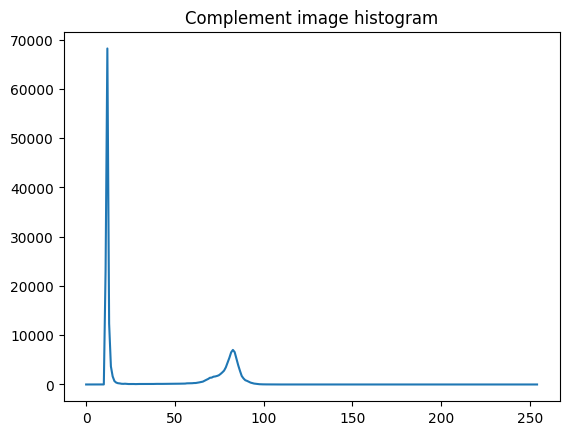

In [5]:
util.show_histogram(complement, "Complement image histogram", grayscale=True)

In [6]:
thresh = filter.filter_threshold(complement, threshold=50)
util.display_img(thresh)

Threshold            | Time: 0:00:00.000162  Type: bool    Shape: (408, 466)


In [7]:
util.display_img(util.mask_rgb(np_img, thresh))

Mask RGB             | Time: 0:00:00.001310  Type: uint8   Shape: (408, 466, 3)


# Otsu threshold

In [8]:
otsu = filter.filter_otsu_threshold(complement)
util.display_img(otsu)
util.display_img(util.mask_rgb(np_img, otsu))

Otsu Threshold       | Time: 0:00:00.118646  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001179  Type: uint8   Shape: (408, 466, 3)


# Binary closing
Fill in small holes in binary mask by dialation, then erosion. 

In [9]:
bin_closing = filter.filter_binary_closing(otsu, disk_size=10)
util.display_img(bin_closing)
util.display_img(util.mask_rgb(np_img, bin_closing))

Binary Closing       | Time: 0:00:00.088512  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001118  Type: uint8   Shape: (408, 466, 3)


# Binary opening
Expand small holes in binary mask by erosion, then dialation.

In [10]:
bin_opening = filter.filter_binary_opening(otsu, disk_size=10)
util.display_img(bin_opening)
util.display_img(util.mask_rgb(np_img, bin_opening))

Binary Opening       | Time: 0:00:00.087682  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001023  Type: uint8   Shape: (408, 466, 3)


# Remove small objects

In [11]:
rm_obj = filter.filter_remove_small_objects(otsu)
util.display_img(rm_obj)
util.display_img(util.mask_rgb(np_img, rm_obj))

Remove Small Objs    | Time: 0:00:00.007024  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.000961  Type: uint8   Shape: (408, 466, 3)


# Remove small holes

In [12]:
rm_hole = filter.filter_remove_small_holes(otsu)
util.display_img(rm_hole)
util.display_img(util.mask_rgb(np_img, rm_hole))

/Users/oliviashen/Desktop/fall24/rubinet/DeskBrainSec/wsi/filter.py:268: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  rem_sm = sk_morphology.remove_small_holes(np_img, area_threshold=min_size)


Remove Small Holes   | Time: 0:00:00.011636  Type: uint8   Shape: (408, 466)
Mask RGB             | Time: 0:00:00.001674  Type: uint8   Shape: (408, 466, 3)


# RGB to HED color space
- H = hematosylin, dyes nucleic acids purple-blue,
- E = eosin, dyes tissues pink
- D = diaminobenzoate, dyes amyloid plaques brown

Extract a sample patch from the WSI:

In [13]:
import skimage.filters as sk_filters

In [14]:
def read_patch(filepath, scale):
  svs = slide.open_slide(filepath)
  w, h = svs.dimensions
  location = (int(w/2), int(h/2))
  size_factor = scale * 10
  size = (int(w/size_factor), int(h/size_factor))
  level = svs.get_best_level_for_downsample(scale)
  return svs.read_region(location, level, size).convert('RGB')

In [15]:
patch = util.pil_to_np_rgb(read_patch(FILE, 4))
util.display_img(patch)

RGB                  | Time: 0:00:00.000686  Type: uint8   Shape: (653, 747, 3)


Filter for diaminobenzoate channel (indicates amyloid plaques)

In [17]:
hed_patch = filter.filter_rgb_to_hed(patch)
dab = filter.filter_hed_to_dab(hed_patch)
dab = np.astype(sk_filters.gaussian(dab) * 255, "uint8")
util.display_img(dab)

RGB to HED           | Time: 0:00:00.045841  Type: uint8   Shape: (653, 747, 3)
HED to DAB           | Time: 0:00:00.003890  Type: uint8   Shape: (653, 747)


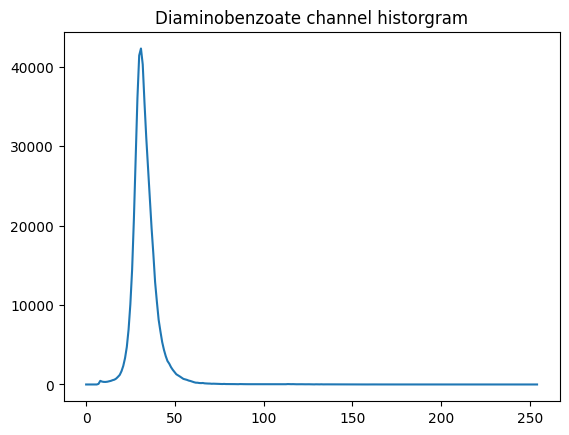

Threshold            | Time: 0:00:00.000102  Type: bool    Shape: (653, 747)
Mask RGB             | Time: 0:00:00.001484  Type: uint8   Shape: (653, 747, 3)


In [18]:
util.show_histogram(dab, "Diaminobenzoate channel historgram", grayscale=True)
# util.display_img(filter.filter_threshold(dab, 50))
dab_mask = filter.filter_threshold(dab, 100)
util.display_img(dab_mask)
util.display_img(util.mask_rgb(patch, dab_mask))

In [19]:
hema = filter.filter_hed_to_hematoxylin(hed_patch)
hema = sk_filters.gaussian(hema)
util.display_img(hema)
#plaque = np.clip(dab - (hema / 2), 0, 255)
#util.display_img(plaque)

HED to Hematoxylin   | Time: 0:00:00.006436  Type: uint8   Shape: (653, 747)
